In [12]:
# 1. Setup and Imports
import sys
sys.path.append("yolov5")  

import os
from pathlib import Path
import cv2
import torch
import pandas as pd
import matplotlib.pyplot as plt

from yolov5.utils.general import non_max_suppression
from yolov5.utils.torch_utils import select_device
from yolov5.models.common import DetectMultiBackend

from arabic_ocr_utils import run_arabic_ocr

In [13]:
# Display images inline
%matplotlib inline

# Set device
device = select_device('')


YOLOv5  v7.0-421-g79c4c31d Python-3.12.1 torch-2.7.0+cpu CPU



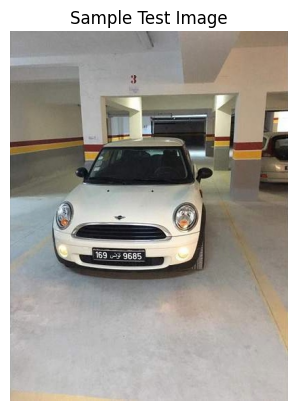

In [17]:
#  2. Load Sample Image
sample_img_path = Path("../test").glob("*.jpg")
sample_img_path = r"D:\Car_num\test\901.jpg"  
img = cv2.imread(str(sample_img_path))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Test Image")
plt.axis('off')
plt.show()

In [19]:
# 3. Load YOLOv5 Model
model_path = r"D:\Car_num\yolov5\runs\train\exp2\weights\best.pt"  
model = DetectMultiBackend(model_path, device=device)
model.eval()


Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs


DetectMultiBackend(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(

In [21]:
# 4. Define Detection + OCR Function
def detect_plate_and_read(img_path):
    original_img = cv2.imread(img_path)
    img_resized = cv2.resize(original_img, (640, 640))
    img_tensor = img_resized[:, :, ::-1].copy().transpose(2, 0, 1)  # BGR → RGB
    img_tensor = torch.from_numpy(img_tensor).float().to(device) / 255.0
    img_tensor = img_tensor.unsqueeze(0)

    pred = model(img_tensor)[0]
    pred = non_max_suppression(pred, 0.25, 0.45)[0]

    if pred is None or len(pred) == 0:
        return "NO DETECTION"

    box = pred[0][:4].cpu().numpy().astype(int)
    x1, y1, x2, y2 = box
    plate_crop = original_img[y1:y2, x1:x2]
    temp_path = "temp_crop.jpg"
    cv2.imwrite(temp_path, plate_crop)
    return run_arabic_ocr(temp_path)

In [22]:
# 5. Run on All Test Images and Save Output
results = []
test_dir = Path("../test_set/images")
image_paths = sorted(list(test_dir.glob("*.jpg")))

In [25]:
for img_path in image_paths:
    pred_text = detect_plate_and_read(str(img_path))
    results.append((img_path.name, pred_text))

# Save to CSV
df = pd.DataFrame(results, columns=["filename", "predicted_text"])
df.to_csv("../test_predictions.csv", index=False)
print(" Predictions saved to test_predictions.csv")


 Predictions saved to test_predictions.csv
